In [19]:
# Import all required libraries for modeling and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier


# K-Nearest Neighbors (kNN) Modeling with a 2-Stage Classification System

In this notebook, we implement a 2-stage kNN classification approach to improve performance on underrepresented classes, especially prediabetes.

### Steps:
1. **Merge Class 1 (Prediabetes) and Class 2 (Diabetes)** into a single class for binary classification.
2. **Stage 1:** Train a kNN model to classify between:
   - Class 0 = No Diabetes  
   - Class 1/2 = Combined group  
3. **Stage 2:** For predictions in the combined group, train a second kNN model to distinguish between:
   - Class 1 = Prediabetes  
   - Class 2 = Diabetes  


In [20]:
file_path = "../data/cleaned_diabetes_health_indicators_dataset.csv"
df = pd.read_csv(file_path)

In [27]:
# Separate features (X) and target variable (y)
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']


In [28]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [29]:
# Standardize features for kNN performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
# Convert target to binary: 0 = No Diabetes, 1 = At-Risk (1 or 2)
y_train_stage1 = y_train.copy()
y_train_stage1[y_train_stage1 != 0] = 1

y_test_stage1 = y_test.copy()
y_test_stage1[y_test_stage1 != 0] = 1


In [31]:
# Train a kNN classifier to separate 0 vs At-Risk
knn_stage1 = KNeighborsClassifier(n_neighbors=5)
knn_stage1.fit(X_train_scaled, y_train_stage1)


KNeighborsClassifier()

In [32]:
# Predict using Stage 1 model and print evaluation metrics
y_pred_stage1 = knn_stage1.predict(X_test_scaled)
print("Stage 1 Classification Report (0 vs At-Risk):")
print(classification_report(y_test_stage1, y_pred_stage1))


Stage 1 Classification Report (0 vs At-Risk):
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     38012
         1.0       0.43      0.24      0.30      7945

    accuracy                           0.81     45957
   macro avg       0.64      0.58      0.60     45957
weighted avg       0.78      0.81      0.79     45957



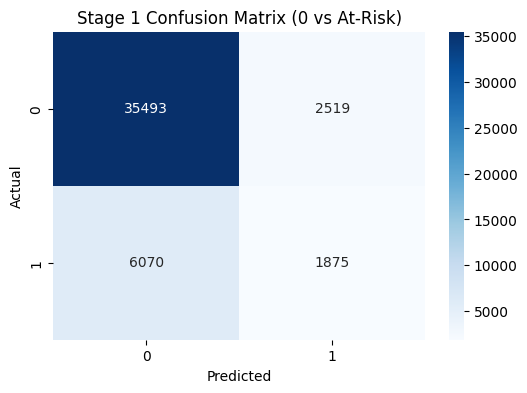

In [33]:
# Visualize confusion matrix for Stage 1
cm_stage1 = confusion_matrix(y_test_stage1, y_pred_stage1)
plt.figure(figsize=(6,4))
sns.heatmap(cm_stage1, annot=True, fmt='d', cmap='Blues')
plt.title('Stage 1 Confusion Matrix (0 vs At-Risk)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [34]:
# Filter test samples where Stage 1 predicted 'At-Risk'
stage2_indices = (y_pred_stage1 == 1)
X_test_stage2 = X_test_scaled[stage2_indices]
y_test_stage2 = y_test.iloc[stage2_indices].copy()


In [36]:
# Stage 1: We assume y_pred_stage1 is already available from the first kNN model
# Now, we select only the test samples that were predicted as "At-Risk" (class 1)

# Step 1: Get indices from y_test that were predicted as class 1 by stage 1
stage2_indices = (y_pred_stage1 == 1)

# Step 2: Subset y_test and X_test using those indices
# Make sure we slice from y_test and X_test_scaled directly, not from full y or X
X_test_stage2 = X_test_scaled[stage2_indices]
y_test_stage2 = y_test.reset_index(drop=True)[stage2_indices]  # reset index to match length

# Step 3: Keep only class 1 and 2, and re-label them as binary (0 = prediabetes, 1 = diabetes)
valid_indices = (y_test_stage2 != 0)
X_test_stage2 = X_test_stage2[valid_indices.values]
y_test_stage2 = y_test_stage2[valid_indices]
y_test_stage2_adjusted = y_test_stage2 - 1


In [37]:
# Step 4: Train a binary kNN classifier on full training data (only class 1 and 2)
# First, filter training set the same way

y_train_binary = y_train[y_train != 0]
X_train_binary = X_train_scaled[y_train != 0]
y_train_binary_adjusted = y_train_binary - 1  # 0 = prediabetes, 1 = diabetes

# Train the second-stage kNN model
knn_stage2 = KNeighborsClassifier(n_neighbors=5)
knn_stage2.fit(X_train_binary, y_train_binary_adjusted)


KNeighborsClassifier()

In [38]:
# Step 5: Predict the binary class (0 or 1) for those flagged as "At-Risk" in Stage 1
y_pred_stage2 = knn_stage2.predict(X_test_stage2)

# Step 6: Print performance metrics
print("Stage 2 - Binary Classification (Prediabetes vs Diabetes)")
print("Accuracy Score:", accuracy_score(y_test_stage2_adjusted, y_pred_stage2))
print("\nClassification Report:\n")
print(classification_report(y_test_stage2_adjusted, y_pred_stage2))


Stage 2 - Binary Classification (Prediabetes vs Diabetes)
Accuracy Score: 0.9114666666666666

Classification Report:

              precision    recall  f1-score   support

         0.0       0.20      0.01      0.02       160
         1.0       0.92      1.00      0.95      1715

    accuracy                           0.91      1875
   macro avg       0.56      0.50      0.49      1875
weighted avg       0.85      0.91      0.87      1875



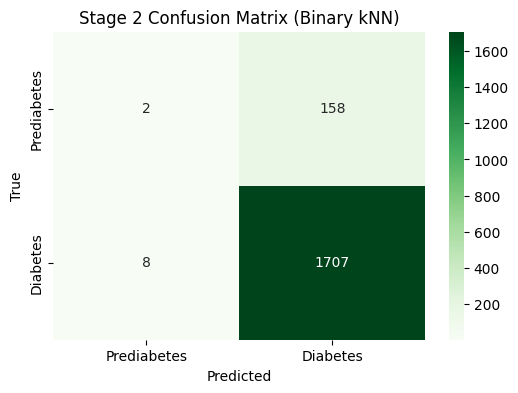

In [39]:
# Step 7: Plot confusion matrix
cm_stage2 = confusion_matrix(y_test_stage2_adjusted, y_pred_stage2)
plt.figure(figsize=(6,4))
sns.heatmap(cm_stage2, annot=True, fmt='d', cmap='Greens', xticklabels=['Prediabetes','Diabetes'], yticklabels=['Prediabetes','Diabetes'])
plt.title("Stage 2 Confusion Matrix (Binary kNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


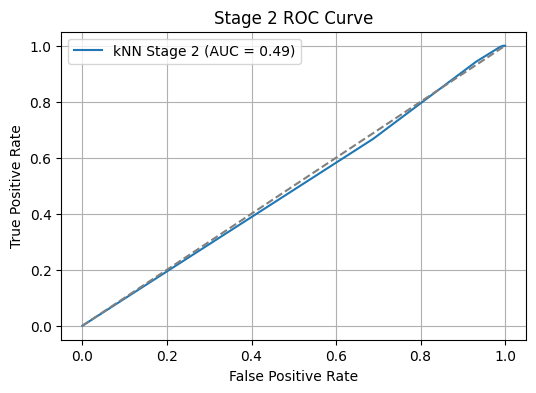

In [40]:
# Step 8: Plot ROC curve for Stage 2
y_proba_stage2 = knn_stage2.predict_proba(X_test_stage2)[:,1]
fpr, tpr, _ = roc_curve(y_test_stage2_adjusted, y_proba_stage2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'kNN Stage 2 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Stage 2 ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
